# Hubert Stefanski -- 20081102@mail.wit.ie -- Text-Mining -- CA

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import re

plt.style.use("seaborn-darkgrid")

SEED = 666


## Load Dataset and Cleanup

In [2]:
df = pd.read_csv("data/wapo_trumpclaims_export-012021.csv.gz")
print(df.shape)
df.head(2)

(30573, 9)


,id,location,claim,analysis,pinocchios,category,repeated_ids,repeated_count,date
0,31608.0,Remarks,"“We also got tax cuts, the largest tax cut and...","This is Trump’s second favorite falsehood, and...",4.0,Taxes,"31608, 31581, 31305, 31183, 31530, 30920, 3085...",296,01/20/2021
1,31609.0,Remarks,“We just got seventy five million votes. And t...,"When the counting was finished, Trump had rece...",NaN,Election,"31609, 31292, 31155, 31016, 31082, 30992, 3156...",19,01/20/2021


In [3]:
df.category.value_counts(dropna=True)

Immigration            3225
Foreign policy         3165
Election               3037
Miscellaneous          2767
Coronavirus            2521
Trade                  2513
Economy                2475
Russia                 1838
Jobs                   1732
Health care            1629
Ukraine probe          1377
Environment            1065
Biographical record     963
Taxes                   857
Crime                   852
Guns                    165
Education               151
Terrorism                72
Name: category, dtype: int64

In [4]:
# criteria = df.category.isin(["Immigration","Coronavirus"])
df = df.loc[:,["claim","category","location","date"]].copy()

In [5]:
df.category.value_counts()

Immigration            3225
Foreign policy         3165
Election               3037
Miscellaneous          2767
Coronavirus            2521
Trade                  2513
Economy                2475
Russia                 1838
Jobs                   1732
Health care            1629
Ukraine probe          1377
Environment            1065
Biographical record     963
Taxes                   857
Crime                   852
Guns                    165
Education               151
Terrorism                72
Name: category, dtype: int64

In [6]:
def clean_text(text):
    text = re.sub(r"'", '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.twitter\S+', '', text)
    text = re.sub(r'\W+', ' ', text.lower())

    return text

In [7]:
df.dropna(subset=['category'], inplace=True) ## Drop Na from target

print(f"Pre-duplicate drop: {df.shape}") ## Check shape before dropping duplicates

df.drop_duplicates(inplace=True)
print(f"Post-duplicate drop: {df.shape}") ## Check shape after dropping duplicates, if they exist the shape should change

df['claim-clean'] = df['claim'].apply(clean_text)
drop_index = []

for i in range(len(df)):
    if df['claim'].iloc[i] in ('', ' '):
        drop_index.append(i)

df.drop(drop_index, inplace=True)

Pre-duplicate drop: (30404, 4)
Post-duplicate drop: (30355, 4)


In [8]:
df.date.str.replace("/","")

0        01202021
1        01202021
2        01202021
3        01202021
4        01202021
           ...   
30568    01202017
30569    01202017
30570    01202017
30571    01202017
30572    01202017
Name: date, Length: 30355, dtype: object

In [9]:
df.location.value_counts(dropna=False)

Campaign rally       9479
Remarks              6205
Interview            4969
Twitter              4694
Speech               2763
News conference      1894
Vlog                  148
Statement             123
Leaked transcript      80
Name: location, dtype: int64

In [10]:
# sns.histplot(x='date',data=df) // COMMENTED OUT DUE TO VERSION ISSUE

## Feature Engineering

In [11]:
wordlist = """
a
able
about
above
according
accordingly
across
actually
after
afterwards
again
against
ain't
all
allow
allows
almost
alone
along
already
also
although
always
am
among
amongst
an
and
another
any
anybody
anyhow
anyone
anything
anyway
anyways
anywhere
apart
appear
appreciate
appropriate
are
aren't
around
as
a's
aside
ask
asking
associated
at
available
away
awfully
be
became
because
become
becomes
becoming
been
before
beforehand
behind
being
believe
below
beside
besides
best
better
between
beyond
both
brief
but
by
came
can
cannot
cant
can't
cause
causes
certain
certainly
changes
clearly
c'mon
co
com
come
comes
concerning
consequently
consider
considering
contain
containing
contains
corresponding
could
couldn't
course
c's
currently
definitely
described
despite
did
didn't
different
do
does
doesn't
doing
don
done
don't
down
downwards
during
each
edu
eg
eight
either
else
elsewhere
enough
entirely
especially
et
etc
even
ever
every
everybody
everyone
everything
everywhere
ex
exactly
example
except
far
few
fifth
first
five
followed
following
follows
for
former
formerly
forth
four
from
further
furthermore
get
gets
getting
given
gives
go
goes
going
gone
got
gotten
greetings
had
hadn't
happens
hardly
has
hasn't
have
haven't
having
he
he'd
he'll
hello
help
hence
her
here
hereafter
hereby
herein
here's
hereupon
hers
herself
he's
hi
him
himself
his
hither
hopefully
how
howbeit
however
how's
i
i'd
ie
if
ignored
i'll
i'm
immediate
in
inasmuch
inc
indeed
indicate
indicated
indicates
inner
insofar
instead
into
inward
is
isn't
it
it'd
it'll
its
it's
itself
i've
just
keep
keeps
kept
know
known
knows
last
lately
later
latter
latterly
least
less
lest
let
let's
like
liked
likely
little
look
looking
looks
ltd
mainly
many
may
maybe
me
mean
meanwhile
merely
might
more
moreover
most
mostly
much
must
mustn't
my
myself
name
namely
nd
near
nearly
necessary
need
needs
neither
never
nevertheless
new
next
nine
no
nobody
non
none
noone
nor
normally
not
nothing
novel
now
nowhere
obviously
of
off
often
oh
ok
okay
old
on
once
one
ones
only
onto
or
other
others
otherwise
ought
our
ours
ourselves
out
outside
over
overall
own
particular
particularly
per
perhaps
placed
please
plus
possible
presumably
probably
provides
que
quite
qv
rather
rd
re
really
reasonably
regarding
regardless
regards
relatively
respectively
right
s
said
same
saw
say
saying
says
second
secondly
see
seeing
seem
seemed
seeming
seems
seen
self
selves
sensible
sent
serious
seriously
seven
several
shall
shan't
she
she'd
she'll
she's
should
shouldn't
since
six
so
some
somebody
somehow
someone
something
sometime
sometimes
somewhat
somewhere
soon
sorry
specified
specify
specifying
still
sub
such
sup
sure
t
take
taken
tell
tends
th
than
thank
thanks
thanx
that
thats
that's
the
their
theirs
them
themselves
then
thence
there
thereafter
thereby
therefore
therein
theres
there's
thereupon
these
they
they'd
they'll
they're
they've
think
third
this
thorough
thoroughly
those
though
three
through
throughout
thru
thus
to
together
too
took
toward
towards
tried
tries
truly
try
trying
t's
twice
two
un
under
unfortunately
unless
unlikely
until
unto
up
upon
us
use
used
useful
uses
using
usually
value
various
very
via
viz
vs
want
wants
was
wasn't
way
we
we'd
welcome
well
we'll
went
were
we're
weren't
we've
what
whatever
what's
when
whence
whenever
when's
where
whereafter
whereas
whereby
wherein
where's
whereupon
wherever
whether
which
while
whither
who
whoever
whole
whom
who's
whose
why
why's
will
willing
wish
with
within
without
wonder
won't
would
wouldn't
yes
yet
you
you'd
you'll
your
you're
yours
yourself
yourselves
you've
zero
"""
wordlist.split()

['a',
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 "a's",
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'came',
 'can',
 'cannot',
 'cant',
 "can't",
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 "c'mon",
 'co',
 'com',
 'come',
 'comes',
 'concerning'

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=2,stop_words=wordlist.split(),strip_accents='unicode',)
X_tfidf = tfidf.fit_transform(df['claim-clean'])

/usr/lib64/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'mustn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.category, test_size=0.4, stratify = df.category ,random_state=SEED)

# (X_train.shape,y_train.shape,X_test.shape,y_test.shape)

In [14]:
# df_train, df_test = train_test_split(df, test_size=0.4, stratify = df.category ,random_state=SEED)

Stopped using the functions below due to the fact that I found tfdif to yield better results

In [15]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vectorizer = CountVectorizer(stop_words="english",ngram_range=(1,2),lowercase=True) STOPPED USING THIS DUE TO BETTER RESULTS FROM TFDIF

In [16]:
# X_train_counts = count_vectorizer.fit_transform(X_train)
# X_test_counts = count_vectorizer.transform(X_test)

# X_test_counts.shape

In [17]:
# print(list(count_vectorizer.get_feature_names()[:100]))

In [18]:
# from sklearn.feature_extraction.text import TfidfTransformer
# tf = TfidfTransformer()

# X_tftrain = tf.fit_transform(X_train_counts)

## Model Building

In [19]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
svc = SVC(gamma="scale",probability=True)
mnb = MultinomialNB()
lgr = LogisticRegression(max_iter=3000,solver='liblinear',random_state=SEED, C=15, n_jobs=-1,class_weight='balanced')
voting = VotingClassifier(estimators=[('logReg', lgr),('DecisionTree', dt), ('SVC', svc), ('MultiBiNom', mnb)],
                           voting='soft', n_jobs=-1)

models = [
#           dt, ## ABSOLUTELY USELESS <13%
#           sv, ## COMMENT THIS OUT IF YOU LIKE WASTING YOUR TIME
#           mnb,
          lgr,
#           voting
         ]


In [20]:
for model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f"-------------{model}------------------------------------------")
    print(classification_report(y_test,y_pred,zero_division=True,digits=4))
    



/usr/lib64/python3.9/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


-------------LogisticRegression(C=15, class_weight='balanced', max_iter=3000, n_jobs=-1,
                   random_state=666, solver='liblinear')------------------------------------------
                     precision    recall  f1-score   support

Biographical record     0.5984    0.5766    0.5873       385
        Coronavirus     0.8859    0.8780    0.8819      1008
              Crime     0.7372    0.7176    0.7273       340
            Economy     0.8275    0.7958    0.8113       989
          Education     0.9444    0.8793    0.9107        58
           Election     0.7973    0.7776    0.7873      1214
        Environment     0.8717    0.8451    0.8582       426
     Foreign policy     0.8596    0.8759    0.8677      1265
               Guns     0.8507    0.8636    0.8571        66
        Health care     0.8783    0.8796    0.8790       648
        Immigration     0.9080    0.9052    0.9066      1287
               Jobs     0.8277    0.8900    0.8577       691
      Miscellaneou

In [21]:
print(classification_report(y_test,y_pred,zero_division=True,digits=4))

                     precision    recall  f1-score   support

Biographical record     0.5984    0.5766    0.5873       385
        Coronavirus     0.8859    0.8780    0.8819      1008
              Crime     0.7372    0.7176    0.7273       340
            Economy     0.8275    0.7958    0.8113       989
          Education     0.9444    0.8793    0.9107        58
           Election     0.7973    0.7776    0.7873      1214
        Environment     0.8717    0.8451    0.8582       426
     Foreign policy     0.8596    0.8759    0.8677      1265
               Guns     0.8507    0.8636    0.8571        66
        Health care     0.8783    0.8796    0.8790       648
        Immigration     0.9080    0.9052    0.9066      1287
               Jobs     0.8277    0.8900    0.8577       691
      Miscellaneous     0.5915    0.5904    0.5910      1106
             Russia     0.8613    0.8531    0.8571       735
              Taxes     0.8898    0.9211    0.9052       342
          Terrorism    

In [22]:
df_cm = pd.crosstab(y_test,y_pred)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm

Predicted,Biographical record,Coronavirus,Crime,Economy,Education,Election,Environment,Foreign policy,Guns,Health care,Immigration,Jobs,Miscellaneous,Russia,Taxes,Terrorism,Trade,Ukraine probe
Actual,,,,,,,,,,,,,,,,,,
Biographical record,222,3,1,17,0,26,3,17,0,4,5,2,72,4,2,0,6,1
Coronavirus,4,885,0,24,0,9,4,14,0,6,10,5,37,3,0,0,5,2
Crime,0,3,244,2,0,11,0,5,1,1,26,1,38,4,0,0,1,3
Economy,9,13,1,787,1,8,17,16,0,3,7,61,28,1,12,0,23,2
Education,1,0,0,1,51,0,0,0,0,0,0,0,4,0,0,0,1,0
Election,34,10,26,11,0,944,1,10,2,1,12,2,95,24,7,0,3,32
Environment,3,8,0,5,0,3,360,8,0,1,3,7,16,0,0,0,11,1
Foreign policy,6,20,2,12,0,14,4,1108,0,2,14,2,35,10,1,4,24,7
Guns,0,3,0,1,0,3,1,0,57,0,0,0,1,0,0,0,0,0


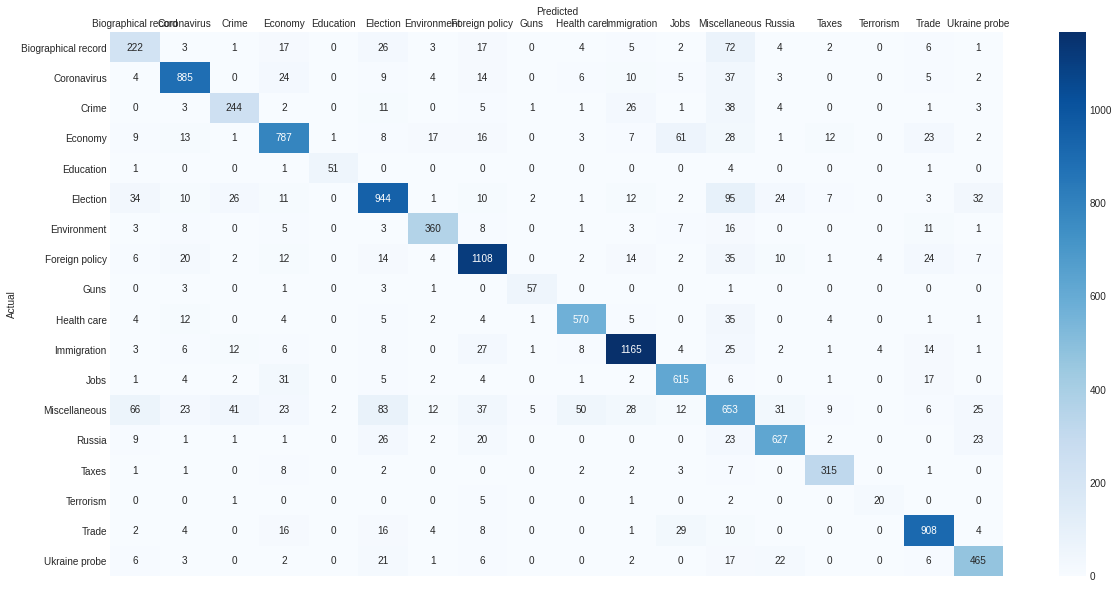

In [23]:
plt.figure(figsize=(20,10))
g = sns.heatmap(df_cm,annot=True,fmt="d",cmap="Blues")
g.xaxis.set_ticks_position('top')
g.xaxis.set_label_position('top')

In [24]:
print(classification_report(y_test, y_pred, zero_division=0, digits=4))

                     precision    recall  f1-score   support

Biographical record     0.5984    0.5766    0.5873       385
        Coronavirus     0.8859    0.8780    0.8819      1008
              Crime     0.7372    0.7176    0.7273       340
            Economy     0.8275    0.7958    0.8113       989
          Education     0.9444    0.8793    0.9107        58
           Election     0.7973    0.7776    0.7873      1214
        Environment     0.8717    0.8451    0.8582       426
     Foreign policy     0.8596    0.8759    0.8677      1265
               Guns     0.8507    0.8636    0.8571        66
        Health care     0.8783    0.8796    0.8790       648
        Immigration     0.9080    0.9052    0.9066      1287
               Jobs     0.8277    0.8900    0.8577       691
      Miscellaneous     0.5915    0.5904    0.5910      1106
             Russia     0.8613    0.8531    0.8571       735
              Taxes     0.8898    0.9211    0.9052       342
          Terrorism    